# ABAQUS Test on Capped Indentor into Sphere
Authors: J. Giblin-Burnham


Applying ABAQUS to AFM indentation into elastic spheres of varying radii provides a robust validation of simulation accuracy through comparison with the theoretical contact models. Following the common experimental determination of Young modulus, theoretical contact models are used to fit the Young modulus for simulated indentation force curves of elastic spheres. The elastic sphere moves freely with a fixed, rigid base beneath. Restricting indentation to the z-axis allows the modelling to be asymmetrically centred around the z-axis.



## Imports

In [1]:
# -------------------------------------- Possible modules to pip instal-------------------------------------------------
# import sys
# !{sys.executable} -m pip install pyabaqus==2022
# !{sys.executable} -m pip install paramiko

In [2]:
# --------------------------------------------------System Imports-----------------------------------------------------
import os
import sys
import time
from datetime import timedelta
import subprocess

# -----------------------------------------------Server commands--------------------------------------------------------
import paramiko
from scp import SCPClient
import socket

# ---------------------------------------------Mathematical/Plotting Imports--------------------------------------------
# Importing relevant maths and graphing modules
import numpy as np 
import math
from numpy import random   
from random import randrange
from scipy.optimize import curve_fit

# Plotting import and settinngs
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

linewidth = 11.69/2 # inch

plt.rcParams["figure.figsize"] = (linewidth/3, (1/1.61)*linewidth/3)
plt.rcParams['figure.dpi'] = 256
plt.rcParams['font.size'] = 16
plt.rcParams["font.family"] = "Times New Roman"


plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# For displaying images in Markdown
from IPython.display import Image 

# Abaqus Simulation

## Main Abaqus Script

In [3]:
%%writefile AFMtestCapped_Sphere.py

# ----------------------------------------------Load Modules-----------------------------------------------------------
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import *
from part import *
from material import *
from section import *
from assembly import *
from interaction import *
from mesh import *
from visualization import *
import visualization
import odbAccess
from connectorBehavior import *
import cProfile, pstats, io
import regionToolset
#from abaqus import getInput
executeOnCaeStartup()

# ----------------------------------------------Import variables------------------------------------------------------
spheres = [2.5, 5 ,10,15, 20, 30,40,50,60]

# Cone variables
R_indentor = 5
theta_degrees = 20
theta = theta_degrees*(np.pi/180)
tip_length = 25

# Intercept of spherical and Capped section of indentor (Tangent point) 
x_int, y_int = R_indentor*np.cos(theta), -R_indentor*np.sin(theta)

# Total radius/ footprint of indentor/ top coordinates
x_top, y_top = tip_length*np.tan(theta), tip_length

# Simulation variables
timePeriod = 2.5
timeInterval = 0.1
N = int(timePeriod/ timeInterval)

# Array for data
RFBase = np.zeros([len(spheres),N+1])
U2Base = np.zeros([len(spheres),N+1])
RFIndentor = np.zeros([len(spheres),N+1])
U2Indentor = np.zeros([len(spheres),N+1])

#  ---------------------------------------------------Model-----------------------------------------------------------
for i, r in enumerate(spheres):
    modelName = jobName = 'AFMtestShpere_Indentor-'+str(i)
    model = mdb.Model(name=modelName)

    # ------------------------------------------------Set Parts----------------------------------------------------------- 
    # Create Indentor part
    model.ConstrainedSketch(name = 'indentor', sheetSize=1.0) 
    model.sketches['indentor'].ConstructionLine(point1=(0,-R_indentor),point2=(0,y_top))
    model.sketches['indentor'].ArcByCenterEnds(center=(0,0), point1=(x_int,y_int), point2=(0,-R_indentor), 
                                               direction = CLOCKWISE)
    model.sketches['indentor'].Line(point1=(x_int,y_int), point2=(x_top,y_top))
    model.sketches['indentor'].Line(point1=(0,y_top), point2=(x_top,y_top))
    
    model.Part(name='indentor', dimensionality=AXISYMMETRIC, type= DISCRETE_RIGID_SURFACE)
    model.parts['indentor'].BaseWire(sketch = model.sketches['indentor'])

    # Create Sphere part 
    model.ConstrainedSketch(name = 'sphere', sheetSize=1.0)   
    model.sketches['sphere'].ConstructionLine(point1=(0,r),point2=(0,-r))
    model.sketches['sphere'].ArcByCenterEnds(center=(0,0),point1=(0,r),point2=(0,-r), direction = CLOCKWISE)
    model.sketches['sphere'].Line(point1=(0,r),point2=(0,-r))
    model.Part(name='sphere', dimensionality=AXISYMMETRIC, type=DEFORMABLE_BODY)
    model.parts['sphere'].BaseShell(sketch = model.sketches['sphere'])

    # Create Base Part
    model.ConstrainedSketch(name = 'base', sheetSize=1.0)   
    model.sketches['base'].ConstructionLine(point1=(0,0),point2=(0,r))
    model.sketches['base'].Line(point1=(0,0),point2=(2*r,0))
    model.Part(name='base', dimensionality=AXISYMMETRIC, type= DISCRETE_RIGID_SURFACE)
    model.parts['base'].BaseWire(sketch = model.sketches['base'])


    # ----------------------------------------------Set Geometry----------------------------------------------------------
    # Create geometric sets for referencing
    model.parts['sphere'].Set(faces= model.parts['sphere'].faces, name='sphere_edges')
    model.parts['indentor'].Set(edges= model.parts['indentor'].edges, name='indentor_edges')
    model.parts['base'].Set(edges= model.parts['base'].edges, name='base_edges')

    # Create gemoetric surface for contact
    model.parts['sphere'].Surface(name='sphere_surface', 
                                 side1Edges = model.parts['sphere'].edges.getSequenceFromMask(mask=('[#2]', ), ) )
    model.parts['indentor'].Surface(name='indentor_surface', 
                                    side1Edges = model.parts['indentor'].edges.getSequenceFromMask(
                                        mask=('[#1]','[#2]',),))
    model.parts['base'].Surface(name='base_surface', 
                                 side1Edges = model.parts['base'].edges.getSequenceFromMask(mask=('[#1]', ), ) )

    # Create reference points
    point = model.parts['indentor'].ReferencePoint((0, 0, 0))
    model.parts['indentor'].Set(referencePoints = (model.parts['indentor'].referencePoints[point.id],),
                                name= 'indentor_centre')
    
    point = model.parts['sphere'].ReferencePoint((0, -r, 0))
    model.parts['sphere'].Set(referencePoints = (model.parts['sphere'].referencePoints[point.id],), name='sphere_base')
    
    point = model.parts['base'].ReferencePoint((0, 0, 0))
    model.parts['base'].Set(referencePoints = (model.parts['base'].referencePoints[point.id],), name= 'base_centre')


    # -----------------------------------------------Set Properties-------------------------------------------------------
    # Assign materials
    model.Material(name='sphere_material')
    model.materials['sphere_material'].Elastic(table=((1000, 0.2), ))
    model.HomogeneousSolidSection(name='section', material='sphere_material', thickness=None)
    model.parts['sphere'].SectionAssignment( region = model.parts['sphere'].sets['sphere_edges'], sectionName='section')


    # ----------------------------------------------Set Assembly----------------------------------------------------------
    model.rootAssembly.regenerate()
    
    model.rootAssembly.Instance(name='sphere', part = model.parts['sphere'],dependent=ON)
    model.rootAssembly.Instance(name='indentor', part = model.parts['indentor'], dependent=ON)
    model.rootAssembly.Instance(name='base', part = model.parts['base'], dependent=ON)

    model.rootAssembly.translate(instanceList = ('indentor',) , vector = (0,2*r+R_indentor,0) )
    model.rootAssembly.translate(instanceList = ('sphere',)  , vector = (0,r,0) )

    model.rootAssembly.DatumCsysByDefault(CARTESIAN)


    # ------------------------------------------------Set Steps-----------------------------------------------------------
    step = model.StaticStep(name='Step-1', previous='Initial', description='', timePeriod=timePeriod, 
                            timeIncrementationMethod=AUTOMATIC, maxNumInc=int(1e5), 
                            initialInc=1.0, minInc=1e-25, maxInc=1)
    field = model.FieldOutputRequest('F-Output-1', createStepName='Step-1', variables=('RF', 'TF', 'U'), 
                                     timeInterval = timeInterval)
    model.steps['Step-1'].control.setValues(allowPropagation=OFF, resetDefaultValues=OFF, 
                              timeIncrementation=(4.0, 8.0, 9.0, 16.0, 10.0, 4.0, 12.0, 25.0, 6.0, 3.0, 50.0))


    # ----------------------------------------------Set Interactions------------------------------------------------------
    model.ContactProperty(name = 'Contact Properties')
    model.interactionProperties['Contact Properties'].TangentialBehavior(formulation =ROUGH)
    model.interactionProperties['Contact Properties'].NormalBehavior(pressureOverclosure=HARD)

    model.RigidBody(name= 'indentor_constraint', 
                    bodyRegion = model.rootAssembly.instances['indentor'].sets['indentor_edges'],
                    refPointRegion = model.rootAssembly.instances['indentor'].sets['indentor_centre'])

    model.RigidBody(name= 'base_constraint', 
                    bodyRegion = model.rootAssembly.instances['base'].sets['base_edges'],
                    refPointRegion = model.rootAssembly.instances['base'].sets['base_centre'])

    model.SurfaceToSurfaceContactStd(name    = 'surface-indentor', 
                                     createStepName = 'Initial', 
                                     master = model.rootAssembly.instances['indentor'].surfaces['indentor_surface'], 
                                     slave  = model.rootAssembly.instances['sphere'].surfaces['sphere_surface'],
                                     interactionProperty = 'Contact Properties', 
                                     sliding = FINITE)

    model.SurfaceToSurfaceContactStd(name    = 'base-sphere', 
                                     createStepName = 'Initial', 
                                     master =  model.rootAssembly.instances['base'].surfaces['base_surface'], 
                                     slave  =  model.rootAssembly.instances['sphere'].surfaces['sphere_surface'],
                                     interactionProperty = 'Contact Properties', 
                                     sliding = FINITE)


    # -----------------------------------------------Set Loads------------------------------------------------------------
    # Create surface boundary conditions
    model.DisplacementBC(name='Base-BC',createStepName='Initial', 
                         region= model.rootAssembly.instances['base'].sets['base_edges'], 
                         u1=SET, u2=SET, ur3= SET)
    # Create indentor boundary conditions
    model.DisplacementBC(name='Indentor-U',createStepName='Step-1',
                         region= model.rootAssembly.instances['indentor'].sets['indentor_centre'], 
                         u1=SET, u2=-6, ur3 = SET )


    # ------------------------------------------------Set Mesh------------------------------------------------------------
    #Assign an 'sphere' type to the part instance- seed and generate
    model.rootAssembly.regenerate()
    model.parts['sphere'].seedPart(size = 0.3)    
    model.parts['sphere'].setElementType(model.rootAssembly.instances['sphere'].sets['sphere_edges'], 
                                         elemTypes =(mesh.ElemType(elemCode=TRI,secondOrderAccuracy = ON),) )
    model.parts['sphere'].setMeshControls(regions= model.rootAssembly.instances['sphere'].sets['sphere_edges'].vertices,
                                          elemShape=TRI, technique=FREE)
    model.parts['sphere'].generateMesh()
    
    
    model.parts['indentor'].seedPart(size = 0.1)
    model.parts['indentor'].generateMesh()

    
    model.parts['base'].seedPart(size = 1)
    model.parts['base'].generateMesh()


    # ----------------------------------------------Set Submission--------------------------------------------------------
    # Create an analysis job for the model and submit it.
    job = mdb.Job(name=jobName, model=modelName, description='AFM Sphere')
    job.writeInput()
    job.submit()
    job.waitForCompletion()

    # ----------------------------------------------Set Data extraction--------------------------------------------------

    # Opening the odb and the output database and display a default contour plot.
    odb    = session.openOdb(jobName +'.odb', readOnly=True)
    regionBase     = odb.rootAssembly.nodeSets.values()[1]
    regionIndentor = odb.rootAssembly.nodeSets.values()[2]
    
    # Extracting Step 1, this analysis only had one step
    step1 = odb.steps.values()[0]
        
    n,m,j,k = 0,0,0,0
    # Creating a for loop to iterate through all frames in the step
    
    for x in odb.steps[step1.name].frames:
        # Reading stress and strain data from the model 
        fieldRFBase = x.fieldOutputs['RF'].getSubset(region= regionBase)
        fieldUBase  = x.fieldOutputs['U'].getSubset(region= regionBase)    
                
        fieldRFIndentor = x.fieldOutputs['RF'].getSubset(region= regionIndentor)
        fieldUIndentor  = x.fieldOutputs['U'].getSubset(region= regionIndentor) 
        
        # Storing Stress and strain values for the current frame
        for rf in fieldRFBase.values:
            RFBase[i,j] = rf.data[1]
            j+=1
            
        for u in fieldUBase.values:
            U2Base[i,k] = u.data[1] 
            k+=1    
            
        for rf in fieldRFIndentor.values:
            RFIndentor[i,n] = rf.data[1]
            n+=1
            
        for u in fieldUIndentor.values:
            U2Indentor[i,m] = u.data[1] 
            m+=1    
        
# Writing to a .csv file
np.savetxt("U2Base_Results.csv", U2Base , delimiter=",")
np.savetxt("RFBase_Results.csv", RFBase , delimiter=",")
np.savetxt("U2Indentor_Results.csv", U2Indentor , delimiter=",")
np.savetxt("RFIndentor_Results.csv", RFIndentor , delimiter=",")

# Close the odb
odb.close()

mdb.saveAs('AFMtestCapped_Sphere.cae')

Overwriting AFMtestCapped_Sphere.py


## Submission

In [4]:
# For locally submission
# !abaqus fetch job=AFMtestCapped_Sphere
# !abaqus cae -noGUI AFMtestCapped_Sphere.py

In [5]:
def SSHconnect(remote_server, **kwargs):
    ''' Function to open ssh connecction to remote server. A new Channel is opened and allows requested command to be executed in other functions. 
    The function allows for ProxyJumpp/Port Forwarding/SSH Tunelling.

        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
                                    host (str)       - Hostname of the server to connect to
                                    port (int)       - Server port to connect to 
                                    username (str)   - username to authenticate as (defaults to the current local username)        -  
                                    password (str)   - Used for password authentication, None if ssh-key is used; is also used for private key 
                                                       decryption if passphrase is not given.
                                    sshkey (str)     - Path to private key for keyexchange if password not used, None if not used
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
                                           
        Return: 
            ssh_client (obj) - SHH client object which allows for bash command execution and file transfer.
    '''

    host, port, username, password, sshkey, home, scratch = remote_server

    if 'ProxyJump' in kwargs:
        # Set variables for proxy port
        proxy_host, proxy_port, proxy_username, proxy_password, proxy_sshkey, proxy_home, proxy_scratch = kwargs['ProxyJump']
        hostname = socket.getfqdn()
        remote_addr = (host, int(port))
        local_addr  = (socket.gethostbyname_ex(hostname)[2][0], 22)

        # Create proxy jump/ ssh tunnel
        proxy_client = paramiko.SSHClient()
        proxy_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        proxy_client.connect(proxy_host, int(proxy_port), proxy_username, proxy_password, key_filename=proxy_sshkey)
        transport = proxy_client.get_transport()
        channel = transport.open_channel("direct-tcpip", remote_addr, local_addr)

        # SSH to clusters using paramiko module
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(host, int(port), username, password, key_filename=sshkey, sock=channel)
    
    else: 
        # SSH to clusters using paramiko module
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(host, int(port), username, password, key_filename=sshkey)

    return ssh_client

In [6]:
def RemoteSubmission(remote_server, script, abqCommand, remotePath, localPath, **kwargs):
    '''    
    Function to make directory and transfer files to SSH server. A new Channel is opened and the files are transfered. 
    The commands input and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            files (list)         - File or list of file to transfer
            remotePath (str)     - Path to remote file/directory
            
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
                Analysis (bool)          - If false skip odb analysis step of simulation {Default: True}
                Retrieval (bool)         - If false skip data file retrivial from remote serve {Default: True}
    '''
    
    # SHH to clusters
    ssh_client = SSHconnect(remote_server, **kwargs)

    #  ----------------------------------------------Simulation submission----------------------------------------------------
    if 'Submit' not in kwargs.keys() or kwargs['Submit'] == True:
        t0 = time.time()
        
        print('Producing simulation...')

        # Make working directory
        stdin, stdout, stderr = ssh_client.exec_command('mkdir -p ' + remotePath)

        # SCPCLient takes a paramiko transport as an argument- Uploading content to remote directory
        scp_client = SCPClient(ssh_client.get_transport())
        scp_client.put(script, recursive=True, remote_path = remotePath)
        scp_client.close()
        
        # Execute abaqus command
        stdin, stdout, stderr = ssh_client.exec_command(abqCommand)
        lines = stdout.readlines()
        print(lines)

        t1= time.time()
        print('ABAQUS Simulation Complete - '+ str(timedelta(seconds=t1-t0)) )

    #  -----------------------------------------------File Retrieval----------------------------------------------------------
    if 'Retrieval' not in kwargs.keys() or kwargs['Retrieval'] == True:
        t0 = time.time()

        print('Transfering File')

        os.makedirs('data', exist_ok=True)
        
        # Import data from server
        ftp_client=ssh_client.open_sftp()
        ftp_client.get(os.path.join(remotePath, 'U2Base_Results.csv'), os.path.join(localPath, 'data', 'U2Base_Results.csv'))
        ftp_client.get(os.path.join(remotePath, 'RFBase_Results.csv'), os.path.join(localPath, 'data', 'RFBase_Results.csv'))
        ftp_client.get(os.path.join(remotePath, 'U2Indentor_Results.csv'), os.path.join(localPath, 'data', 'U2Indentor_Results.csv'))
        ftp_client.get(os.path.join(remotePath, 'RFIndentor_Results.csv'), os.path.join(localPath, 'data', 'RFIndentor_Results.csv'))
 

        ftp_client.close()
        ssh_client.close()

        t1 = time.time()
        print('File Transfer Complete - '+ str(timedelta(seconds=t1-t0)) )

    if 'Load' not in kwargs.keys() or kwargs['Load'] == True:
        # Import data to variable
        U2Base = np.array(np.loadtxt(os.path.join('data', 'U2Base_Results.csv'), delimiter=","))
        RFBase = np.array(np.loadtxt(os.path.join('data', 'RFBase_Results.csv'), delimiter=","))
        U2Indentor = np.array(np.loadtxt(os.path.join('data', 'U2Indentor_Results.csv'), delimiter=","))
        RFIndentor = np.array(np.loadtxt(os.path.join('data', 'RFIndentor_Results.csv'), delimiter=","))


        return U2Base, RFBase, U2Indentor, RFIndentor



In [7]:
#  ------------------------------------------Remote Sever and Submission Variables------------------------------------------
remote_server = np.loadtxt('../../ssh/mecheng.csv', dtype=str, delimiter=",")
proxy_server = np.loadtxt('../../ssh/ssh-gateway.csv', dtype=str, delimiter=",")

home = remote_server[-2]
localPath = os.getcwd()
remotePath = home + '/ABAQUS/Capped_Indentor/Conical-Sphere_Indentation2/'
script = 'AFMtestCapped_Sphere.py'
abqCommand  = 'cd ' + remotePath + '\n /opt/abaqus2018/abq2018 cae -noGUI ' + script + ' & \n'

# --------------------------------------------------Variables-----------------------------------------------------
spheres = np.array([2.5, 5 ,10,15,20,30,40,50,60])
E, v  = 1000, 0.3
E_eff = E/(1-v**2)

R_indentor = 5
theta_degrees = 20
theta = theta_degrees*(np.pi/180)

In [8]:
U2Base, RFBase, U2Indentor, RFIndentor = RemoteSubmission(remote_server, script, abqCommand, remotePath, localPath, ProxyJump=proxy_server, Submit=False, Retrieval =True)

# Set force cut off to fit at set maximum indentation force as apposed to depth
RFmax      = abs(RFIndentor[1][abs(RFIndentor)[1]>0][-1] )
RFIndentor = np.ma.masked_greater_equal(abs(RFIndentor), RFmax)
U2Indentor = np.ma.masked_array(abs(U2Indentor), mask = np.ma.getmask(RFIndentor))
RFBase     = np.ma.masked_array(RFBase, mask = np.ma.getmask(RFIndentor))
U2Base     = np.ma.masked_array(U2Base, mask = np.ma.getmask(RFIndentor))

Transfering File
File Transfer Complete - 0:00:00.673455


# Data Proccessing

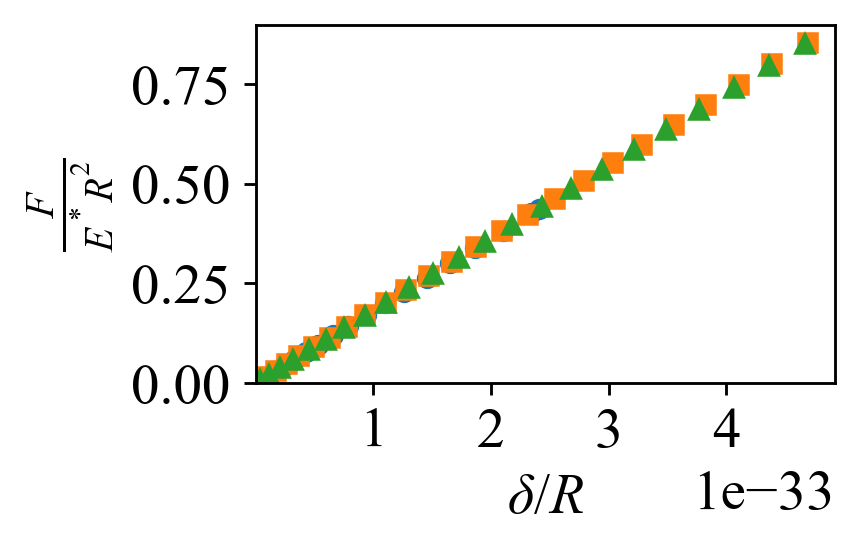

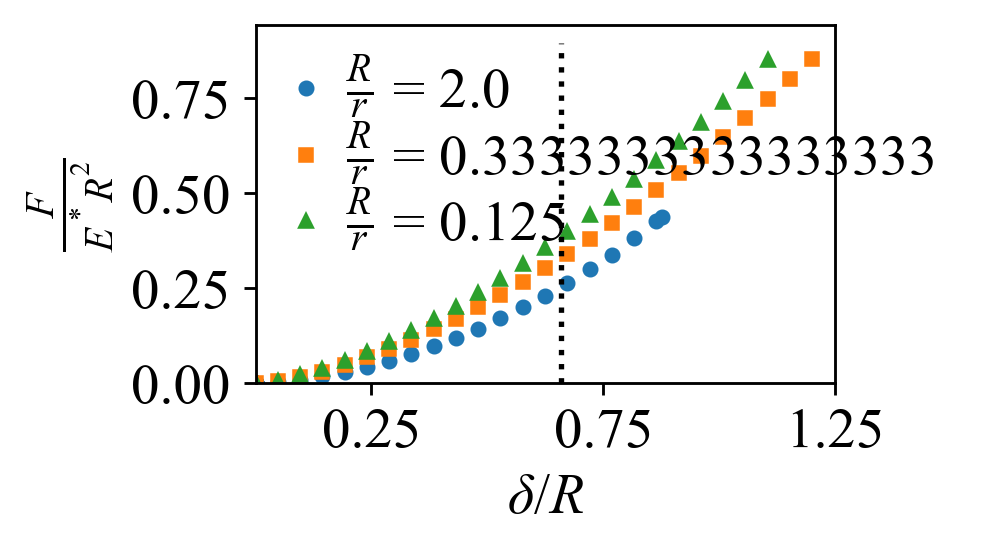

In [9]:
markers = ['o','s','^','H','D','X']
# --------------------------------------------------Plot 1-----------------------------------------------------
fig, ax = plt.subplots(1,1, figsize = (linewidth/2, 1/1.61*linewidth/2))
for i in range(0,len(U2Base), 3):
    ax.plot(-U2Base[i]/R_indentor, RFBase[i]/(E_eff*R_indentor**2), markers[int(i/3)], ms = 5, label = r'$\frac{r}{R}$ = '+str(spheres[i]/R_indentor))
ax.set_xlabel(r'$\delta/R$')
ax.set_ylabel(r'$\frac{F}{E^*R^2}$')
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=4)
plt.show()

# --------------------------------------------------Plot 2-----------------------------------------------------
fig, ax = plt.subplots(1,1, figsize = (linewidth/2, 1/1.61*linewidth/2))
for i in range(0,len(U2Indentor),3):
    ax.plot(U2Indentor[i]/R_indentor, RFIndentor[i]/(E_eff*R_indentor**2), markers[int(i/3)], ms = 3.5, label = r'$\frac{R}{r}$ = '+str(R_indentor/spheres[i]))
ax.vlines((1-np.sin(theta)), 0, ax.get_ylim()[1], 'k', ls=':')

ax.set_xlabel(r'$\delta/R$')
ax.set_ylabel(r'$\frac{F}{E^*R^2}$')
ax.set_xlim([0, 1.25])
ax.set_ylim([0, ax.get_ylim()[1]])

ax.legend(frameon=False, labelspacing=0, loc=[-0.05,0.3],  handletextpad=-0.3)

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=4)
ax.set_xticks([0.25,0.75,1.25])
# ax.set_yticks([0,0.5,0.75])

# fig.savefig('/mnt/c/Users/Joshg/Documents/Manuscript_Figures/Capped-Sphere-Force_Curve-Indenter.pdf', bbox_inches = 'tight', transparent=True)

plt.show()

# Parameter Fit
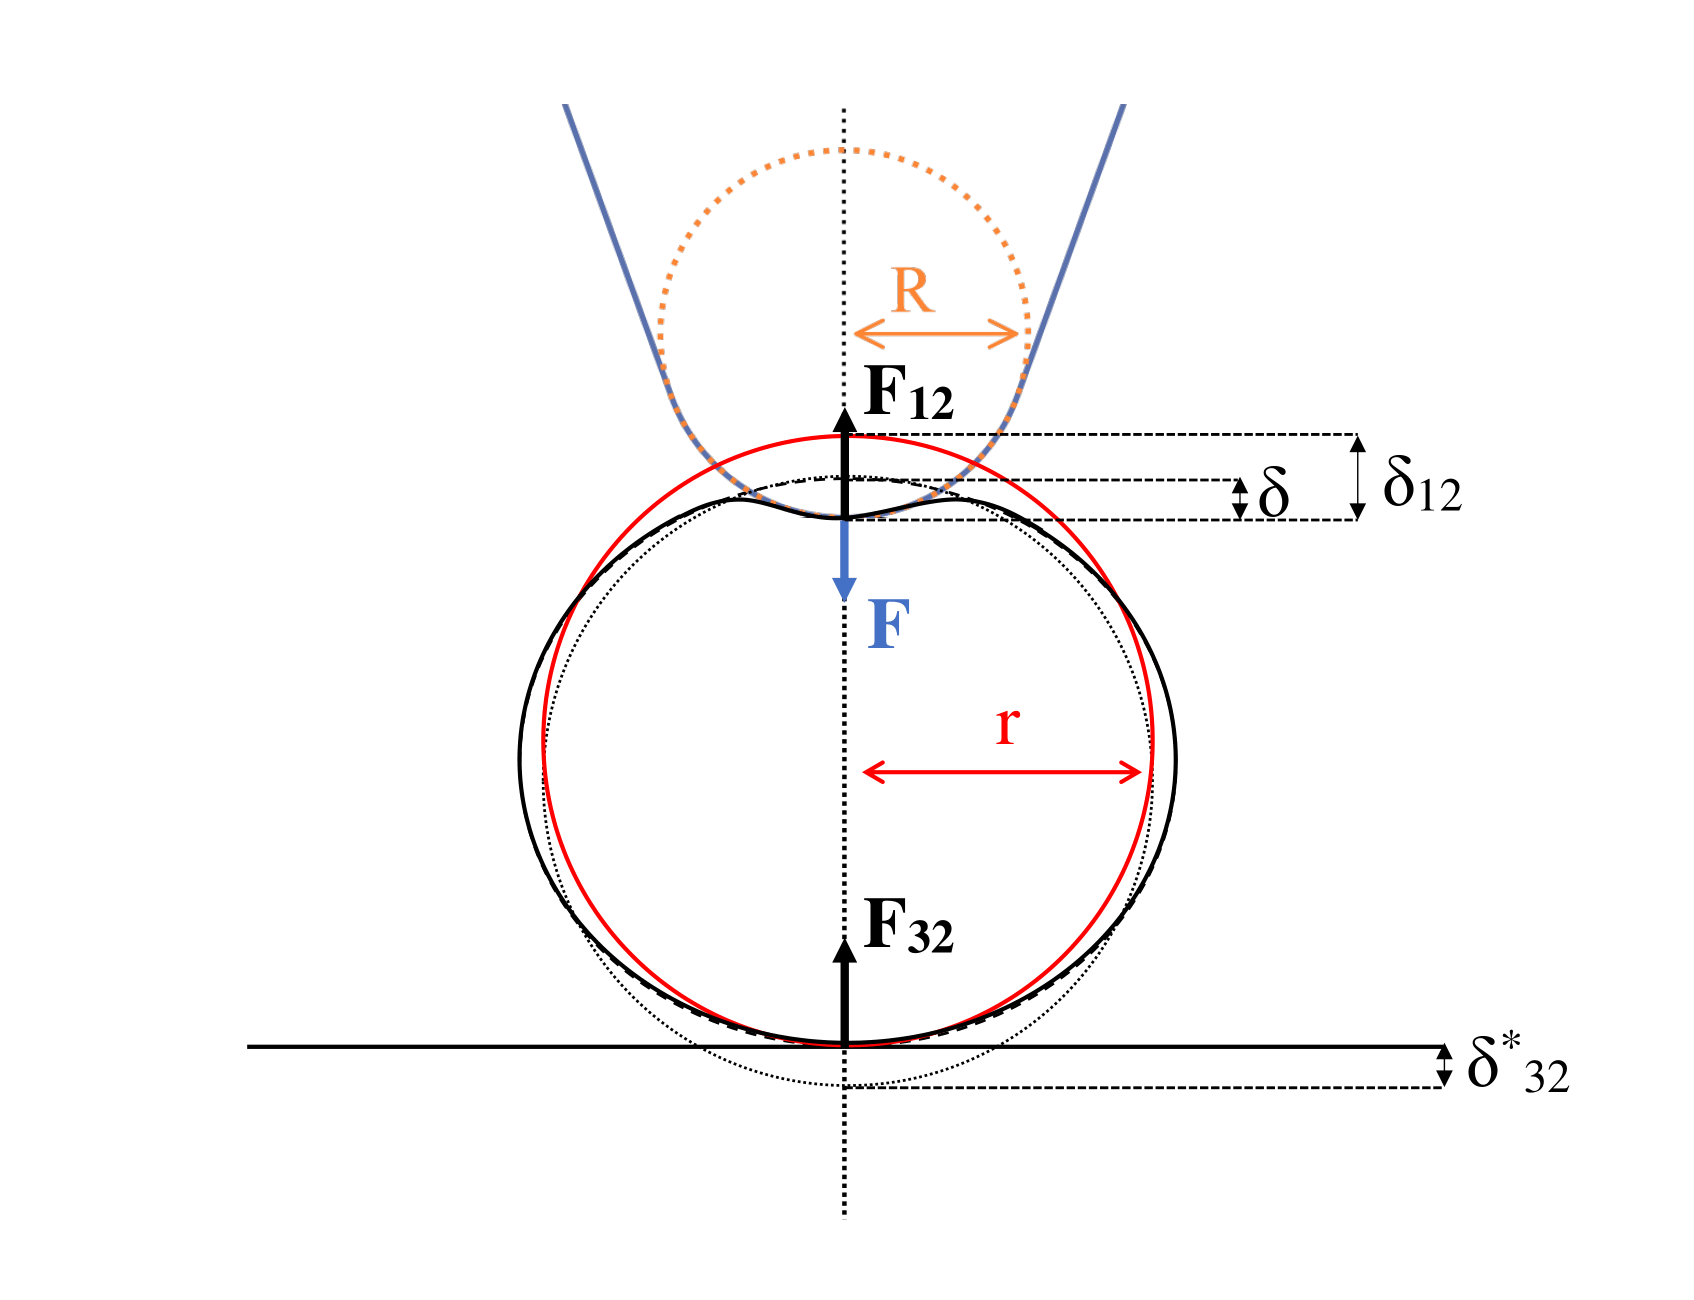

## Simple Hertz Model
$$ F_{Hertz}(\delta) =  \frac{4}{3} \frac{E_2}{(1-\nu_2^2)} \sqrt{R_{12}} \delta^{3/2} $$

$F_{12}$ Contact force experienced on indentor, $F_{32} contact force experienced at base.

$$F_{Hertz} = F_{12}+F_{32}$$
$$\delta = \delta_{12}-\delta^*_{32}$$
$$ \frac{1}{R_{12}} = \frac{1}{R_{1}} + \frac{1}{R_{2}} $$

In [10]:
def F_Hertz(U, E, r): 
    R_eff =1/(1/r +1/R_indentor)
    return (4/3) * (E/(1-v**2)) * np.sqrt(R_eff) * U**(3/2)

In [11]:
E_hertz = np.zeros(len(spheres))
err_hertz =  np.zeros(len(spheres))

x = np.linspace(0,3,40)

for i, r in enumerate(spheres):   
    u2, rf = abs(U2Indentor[i].compressed()), abs(RFIndentor[i].compressed())
    popt, pcov = curve_fit(lambda U, E : F_Hertz(U, E, r), u2, rf)
    
    E_hertz[i] = popt
    err_hertz[i]= pcov

/tmp/ipykernel_64608/2725420144.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hertz[i] = popt
/tmp/ipykernel_64608/2725420144.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err_hertz[i]= pcov


## Spherical Indentor Dimitriadis Model:
https://doi.org/10.1016/S0006-3495(02)75620-8

$$F_{Dimitriadis}(\delta) = \frac{4}{3}\frac{E_{2}}{(1-\nu_{2}^2)}R_{12}^{1/2}\delta^{3/2} \left[ 1 - \frac{2\alpha_0}{\pi}\chi + \left(\frac{2\alpha_0}{\pi}\chi\right)^2 -  \left(\frac{2\alpha_0}{\pi}\chi\right)^3 +  \left(\frac{2\alpha_0}{\pi}\chi\right)^4 -\frac{16}{\pi^2}\beta_0 \left( \frac{2\pi}{15}  - \frac{3}{5}\alpha_0\chi \right)\chi^3   \right]$$

$$F_{Dimitriadis} = F_{12}+F_{32}$$
$$\delta = \delta_{12}-\delta^*_{32}$$
$$ \frac{1}{R_{12}} = \frac{1}{R_{1}} + \frac{1}{R_{2}} $$

$$\chi = \frac{\sqrt{R_{12}\delta}}{h}$$
$$\alpha_0 = -0.347\frac{3-2\nu_{2}}{1-\nu_{2}}$$
$$\beta_0 = 0.056\frac{5-2\nu_{2}}{1-\nu_{2}}$$

In [12]:
E_dim = np.zeros(len(spheres))
err_dim =  np.zeros(len(spheres))

x = np.linspace(0,3,40)

for i, r in enumerate(spheres):
    def F_Dim(U,E):
        alpha = -0.347*(3-2*v)/(1-v)
        beta = 0.056*(5-2*v)/(1-v)
        R_eff =1/(1/r +1/R_indentor)
        chi = np.sqrt(U*R_eff)/(2*r)
        return (4/3) *(E/(1-v**2)) * np.sqrt(R_eff) * U**(3/2)*(1-(2*alpha*chi/np.pi)+(2*alpha*chi/np.pi)**2-(2*alpha*chi/np.pi)**3+(2*alpha*chi/np.pi)**4 - beta*(16/np.pi**2)*(2*np.pi/15-3/5*alpha*chi)*chi**3)
    
    u2, rf = abs(U2Indentor[i]), abs(RFIndentor[i])
    popt, pcov = curve_fit(F_Dim, u2, rf)
    
    E_dim[i] = popt
    err_dim[i]= pcov

/tmp/ipykernel_64608/3076619399.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_dim[i] = popt
/tmp/ipykernel_64608/3076619399.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err_dim[i]= pcov


## Capped Indentor (Sneddon)

#### Flat Surface
$$F(\delta) = \frac{2}{\pi}\frac{E}{(1-\nu^2)}tan(\alpha)\delta^{2}$$

#### Spherical Surface
$$F(\delta) = \frac{2}{\pi}\frac{E}{(1-\nu^2)} \cdot tan(\alpha)U^{2} \cdot f\left(\frac{\delta}{2R_{Surface}}\right)$$

$$ f\left(\frac{\delta}{2R_{Surface}}\right) = 1+ \gamma \left(\frac{\delta}{2R_{Surface}}\right) $$

$$\gamma = −5.103\nu^2 − 13.99\nu + 13.53 $$

In [13]:
def F_Sneddon(U,E,r):
    return (2/np.pi) * (E/(1-v**2))* np.tan(theta) * np.arctan((U)) *(1+(-5.103*v**2-13.99*v+13.53)*(U/2*r)) 
    # return (2/np.pi) * (E/(1-v**2))* np.tan(theta) * U**(2)

In [14]:
E_Sneddon = np.zeros(len(spheres))
err_Sneddon =  np.zeros(len(spheres))
x = np.linspace(0,3,40)

for i, r in enumerate(spheres):
    u2, rf = abs(U2Indentor[i].compressed()), abs(RFIndentor[i].compressed())
    popt, pcov = curve_fit(lambda U, E : F_Sneddon(U, E, r), u2, rf)
    
    E_Sneddon[i] = popt
    err_Sneddon[i]= pcov

/tmp/ipykernel_64608/2528395441.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_Sneddon[i] = popt
/tmp/ipykernel_64608/2528395441.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err_Sneddon[i]= pcov


## Hertz-JKP Double Contact  
https://pubs.rsc.org/en/content/articlelanding/2014/SM/C4SM00788C#cit37

### Surface - Spherical Indentor Indentation (Hertz)
$$ \delta_{12}(F) = \left( \frac{3}{4} \frac{(1-\nu_2^2)}{E_2} \frac{F}{\sqrt{R_{12}}} \right)^{2/3}$$

#### Spherical Surface 
$$ \frac{1}{R_{12}} = \frac{1}{R_{1}} + \frac{1}{R_{2}} $$


###  Corrected Indentation on Base
$F_{12}$ Contact force on indentor/ base, $F_{g}$ gravitational force on base from surface.

$$  \delta(F_{12}) = \delta_{12}(F_{12}) + \delta_{32}^*(F_{12})  $$

$$ =    \left( \frac{3}{4} \frac{(1-\nu_2^2)}{E_2} \frac{F_{12}}{\sqrt{R_{12}}} \right)^{2/3}  +     \left( \frac{3}{4} \frac{(1-\nu_2^2)}{E_2} \frac{F_{12}}{\sqrt{R_{32}}} \right)^{2/3}$$

$$ =    \left( \frac{3}{4} \frac{(1-\nu_2^2)}{E_2} \cdot F_{12} \right)^{2/3} \left[ \frac{1}{R_{12}^{1/3}}  + \frac{1}{R_{32}^{1/3}} \right] $$

$$ =    \left( \frac{3}{4} \frac{(1-\nu_2^2)}{E_2} \cdot F_{12} \right)^{2/3} \left[ \frac{R_{12}^{1/3}+R_{32}^{1/3}}{(R_{12}R_{32})^{1/3}} \right] $$

$$ \implies    F_{12}(\delta) =  \frac{4}{3} \frac{E_2}{(1-\nu_2^2)} \left[ \frac{(R_{12}R_{32})^{1/3}}{R_{12}^{1/3}+R_{32}^{1/3}} \right]^{3/2}\delta^{3/2} $$
$$ \delta = \delta_{12}+ \delta_{32}^*$$

In [15]:
def F_Double(U, E, r): 
    R_eff =1/(1/r +1/R_indentor)
    return (4/3) * (E/(1-v**2)) * ( (R_eff*r)**(1/3) / (R_eff*(1/3) + r**(1/3)) )**(3/2) * U**(3/2)

In [16]:
E_double = np.zeros(len(spheres))
err_double =  np.zeros(len(spheres))

for i, r in enumerate(spheres):
    u2, rf = abs(U2Indentor[i].compressed()), abs(RFIndentor[i].compressed())
    popt, pcov = curve_fit(lambda U,E : F_Double(U,E,r), u2, rf)
    
    E_double[i] = popt
    err_double[i]= pcov

/tmp/ipykernel_64608/3755274634.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_double[i] = popt
/tmp/ipykernel_64608/3755274634.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err_double[i]= pcov


# Comparision

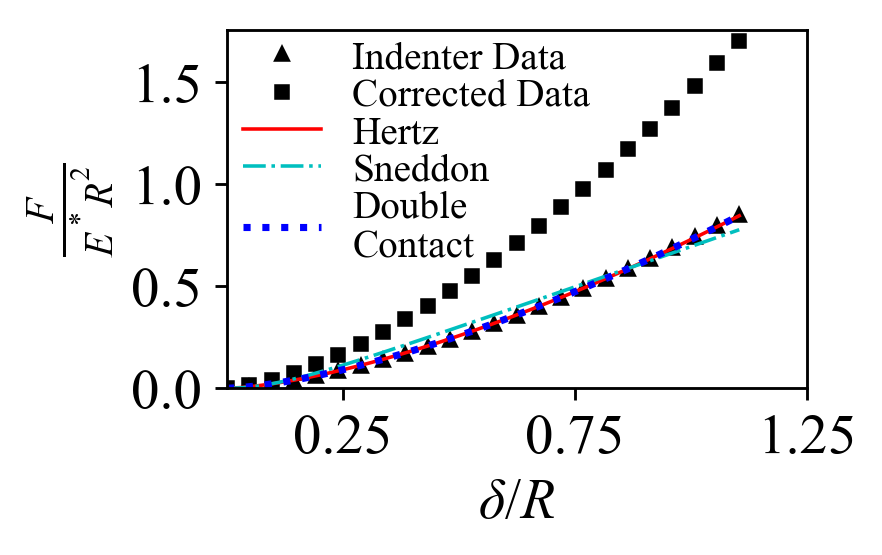

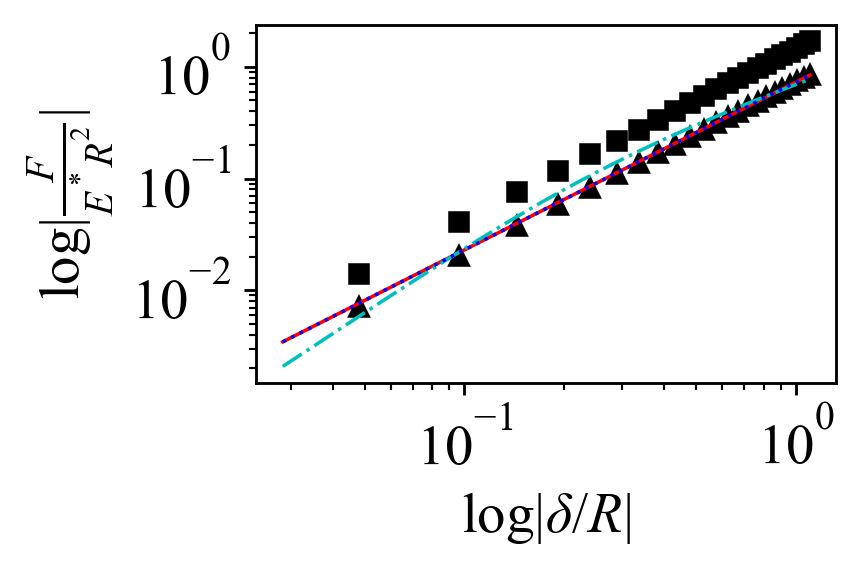

In [17]:
k=-3
r = spheres[k]

x = np.linspace(0, abs(U2Indentor[k]).max(),40)
u2, rf1, rf2 = abs(U2Indentor[k])/R_indentor, abs(RFIndentor[k])/(E_eff*R_indentor**2), abs(RFIndentor[k]+RFBase[k])/(E_eff*R_indentor**2)

# --------------------------------------------------Plot 1-----------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(linewidth/2, 1/1.61*linewidth/2))

ax.plot(u2, rf1, '^', ms = 3.5, lw = 1, color = 'k', label = 'Indenter Data ' )
ax.plot(u2, rf2, 's', ms = 3.5, lw = 1, color = 'k', label = 'Corrected Data' )
ax.plot(x/R_indentor, F_Hertz(x,E_hertz[k], r)/(E_eff*R_indentor**2),   '-',     lw = 1, color = 'r', label = 'Hertz')
ax.plot(x/R_indentor, F_Sneddon(x, E_Sneddon[k], r)/(E_eff*R_indentor**2), '-.', lw = 1, color = 'c', label = 'Sneddon')
ax.plot(x/R_indentor, F_Double(x,E_double[k], r)/(E_eff*R_indentor**2), ':',     lw = 2, color = 'b', label = 'Double\nContact')

ax.set_xlabel(r'$\delta/R$')
ax.set_ylabel(r'$\frac{F}{E^*R^2}$')
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, 1.75])
ax.set_yticks(np.round(10*np.linspace(0,1.5,4))/10)
ax.legend(frameon=False, loc = [0,0.3], labelspacing=0.05, fontsize=11)

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)

ax.set_xlim([0, 1.25])
ax.set_xticks([0.25,0.75,1.25])

# fig.savefig('/mnt/c/Users/Joshg/Documents/Manuscript_Figures/Capped-Sphere-Contact_Models.pdf', bbox_inches = 'tight', transparent=True)
plt.show()


# --------------------------------------------------Plot 2-----------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(linewidth/2, 1/1.61*linewidth/2))

ax.plot((u2[1:]), (rf1[1:]), '^', ms = 5, lw = 1, color = 'k', label = 'Indenter Data')
ax.plot((u2[1:]), (rf2[1:]), 's', ms = 5, lw = 1, color = 'k', label = 'Corrected Data')
ax.plot((x[1:]/R_indentor), (F_Hertz(x,E_hertz[k], r)[1:]/(E_eff*R_indentor**2)), '-',      lw = 1, color = 'r', label = 'Hertz')
ax.plot((x[1:]/R_indentor), (F_Sneddon(x,E_Sneddon[k], r)[1:]/(E_eff*R_indentor**2)), '-.', lw = 1, color = 'c', label = 'Sneddon')
ax.plot((x[1:]/R_indentor), (F_Double(x,E_double[k], r)[1:]/(E_eff*R_indentor**2)), ':',    lw = 1, color = 'b', label = 'Double Contact') 

ax.set_xlabel(r'log|$\delta/R$|')
ax.set_ylabel(r'log|$\frac{F}{E^*R^2}$|')
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

# Youngs Modulus

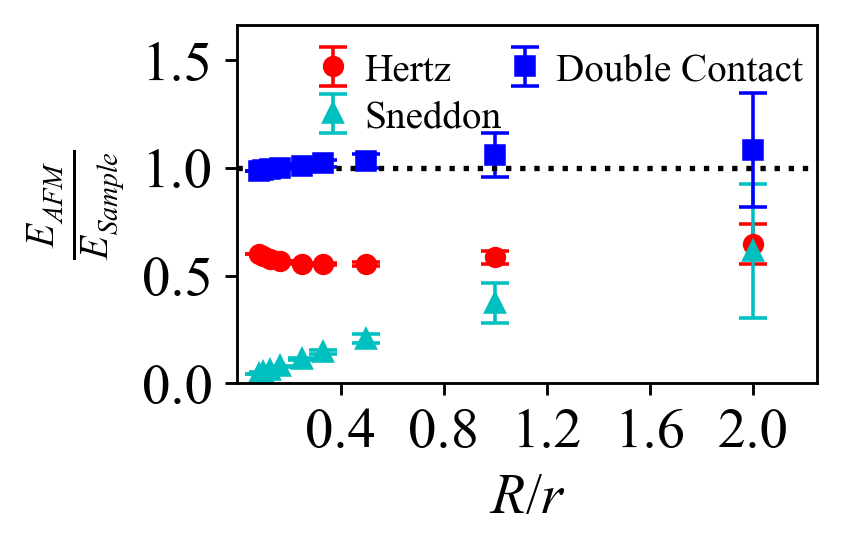

In [39]:
# --------------------------------------------------Plot 1-----------------------------------------------------
fig, ax = plt.subplots(1,1, figsize=(linewidth/2, 1/1.61*linewidth/2))

ax.errorbar(R_indentor/spheres, E_hertz/E,   yerr=err_hertz/E,   fmt='o', color = 'r', lw = 1, ms = 5, capsize=4, label = 'Hertz' )
ax.errorbar(R_indentor/spheres, E_Sneddon/E, yerr=err_Sneddon/E, fmt='^', color = 'c', lw = 1, ms = 5, capsize=4, label = 'Sneddon' )
ax.errorbar(R_indentor/spheres, E_double/E,  yerr=err_double/E,  fmt='s', color = 'b', lw = 1, ms = 5, capsize=4, label = 'Double Contact' )

ax.set_xlabel(r'$R/r$')
ax.set_ylabel(r'$\frac{E_{AFM}}{E_{Sample}}$') 

ax.set_xlim([0, 2.25])
ax.set_ylim([0, ax.get_ylim()[1]+0.25])
ax.legend(frameon=False, ncol=2, loc = [0.07, 0.65], labelspacing=0.3, columnspacing=-0.4, fontsize=11, handletextpad=-0.2)
ax.set_xticks([0.75,1.5,2.25])

ax.hlines(1, 0, ax.get_xlim()[1], ls = ':', color = 'k')

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=4)


# fig.savefig('/mnt/c/Users/Joshg/Documents/Manuscript_Figures/Capped-Sphere-Youngs_Modulus.pdf', bbox_inches = 'tight', transparent=True)
plt.show()